In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['font.size'] = 10

# Importing data

In [ ]:
print("="*100)
print("IMPORTING DATA")
print("="*100)

df_stock_BBRI = pd.read_csv('actual_vs_predicted_BBRI.csv')
df_stock_BBRI['Datetime'] = pd.to_datetime(df_stock_BBRI['Datetime'])

df_sentiment_BBRI = pd.read_csv('BBRI_Sentiment_IndoBERT.csv')
df_sentiment_BBRI['Publish_date'] = pd.to_datetime(df_sentiment_BBRI['Publish_date'])

print("\nStock Data Preview:")
print(df_stock_BBRI.head())
print("\nSentiment Data Preview:")
print(df_sentiment_BBRI.head())

IMPORTING DATA

Stock Data Preview:
                   Datetime    Open    High     Low   Close    Volume  \
0 2025-05-21 14:00:00+07:00  4260.0  4310.0  4250.0  4260.0  88598700   
1 2025-05-21 15:00:00+07:00  4260.0  4270.0  4250.0  4250.0  43763500   
2 2025-05-21 16:00:00+07:00  4260.0  4260.0  4260.0  4260.0  24270100   
3 2025-05-22 09:00:00+07:00  4280.0  4300.0  4240.0  4270.0         0   
4 2025-05-22 10:00:00+07:00  4270.0  4310.0  4270.0  4290.0  50700300   

        EMA_12       EMA_26     RSI_14  Close_Predicted  
0  4247.396766  4217.493944  61.178859      4260.071673  
1  4247.797264  4219.901800  58.308294      4257.445750  
2  4249.674608  4222.872037  60.313652      4253.316154  
3  4252.801591  4226.362997  62.268149      4258.457289  
4  4258.524423  4231.076849  65.886681      4269.791503  

Sentiment Data Preview:
         Publish_date                                                URL  \
0 2025-05-21 08:15:00  https://www.cnbcindonesia.com/market/202505210...   


## Sentiment time preprocessing for BBRI

In [ ]:
print("\n" + "="*100)
print("SENTIMENT TIME PREPROCESSING")
print("="*100)

sentiment_map = {
    'Neutral': 0,
    'Bearish': -1,
    'Bullish': 1
}
try:
    df_sentiment_BBRI['Publish_date'] = df_sentiment_BBRI['Publish_date'].dt.tz_localize('UTC+07:00')
    print("Successfully localized timezone to 'Asia/Jakarta'.")
except Exception as e:
    print(f"Warning during timezone localization: {e}")
    print("Continuing with current timezone assumption...")

df_sentiment_BBRI['sentiment_value'] = df_sentiment_BBRI['sentiment'].map(sentiment_map)
df_sentiment_BBRI['calculated_score'] = df_sentiment_BBRI['sentiment_score'] * df_sentiment_BBRI['sentiment_value']

print("Initial sentiment data processing completed.")

df_sentiment_BBRI['Mapping_Time'] = df_sentiment_BBRI['Publish_date']
cutoff_time = dt.time(16, 0, 0)

# Identify sentiment published after 16:00
is_after_cutoff_BBRI = df_sentiment_BBRI['Publish_date'].dt.time >= cutoff_time

# Move to 9:00 the next day
next_day_normalized = (df_sentiment_BBRI.loc[is_after_cutoff_BBRI, 'Publish_date'] +
                       pd.Timedelta(days=1)).dt.normalize()
market_open_next_day = next_day_normalized + pd.Timedelta(hours=9)
df_sentiment_BBRI.loc[is_after_cutoff_BBRI, 'Mapping_Time'] = market_open_next_day

df_sentiment_to_merge_BBRI = df_sentiment_BBRI[['Mapping_Time', 'calculated_score']].copy()
df_sentiment_to_merge_BBRI = df_sentiment_to_merge_BBRI.sort_values(by='Mapping_Time')

merged_data_BBRI = pd.merge_asof(
    df_sentiment_to_merge_BBRI,
    df_stock_BBRI,
    left_on='Mapping_Time',
    right_on='Datetime',
    direction='forward'
)

df_daily_sentiment_BBRI = merged_data_BBRI.groupby('Datetime')['calculated_score'].mean().reset_index()
df_daily_sentiment_BBRI = df_daily_sentiment_BBRI.rename(columns={'calculated_score': 'average_score'})

print("Sentiment aggregation per trading hour completed.")
print("\nAggregated Sentiment Sample:")
print(df_daily_sentiment_BBRI.head(25))


SENTIMENT TIME PREPROCESSING
Successfully localized timezone to 'Asia/Jakarta'.
Initial sentiment data processing completed.
Sentiment aggregation per trading hour completed.

Aggregated Sentiment Sample:
                    Datetime  average_score
0  2025-05-21 14:00:00+07:00      -0.270948
1  2025-05-21 15:00:00+07:00       0.000000
2  2025-05-21 16:00:00+07:00       0.000000
3  2025-05-22 09:00:00+07:00      -0.172678
4  2025-05-22 10:00:00+07:00       0.000000
5  2025-05-22 11:00:00+07:00      -0.710620
6  2025-05-23 09:00:00+07:00      -0.165062
7  2025-05-23 10:00:00+07:00      -0.604619
8  2025-05-23 14:00:00+07:00       0.000000
9  2025-05-26 09:00:00+07:00      -0.149134
10 2025-05-26 13:00:00+07:00      -0.581868
11 2025-05-26 14:00:00+07:00      -0.498198
12 2025-05-27 13:00:00+07:00       0.000000
13 2025-05-27 14:00:00+07:00       0.000000
14 2025-05-28 09:00:00+07:00       0.153991
15 2025-05-28 13:00:00+07:00      -0.271287
16 2025-06-02 09:00:00+07:00      -0.025899
17

In [ ]:
# Final merge
df_final_BBRI = pd.merge(df_stock_BBRI, df_daily_sentiment_BBRI, on='Datetime', how='left')
df_final_BBRI['average_score'] = df_final_BBRI['average_score'].fillna(0)
df_final_BBRI['Sentiment_value'] = np.where(df_final_BBRI['average_score'] > 0, 1,
                                              np.where(df_final_BBRI['average_score'] < 0, -1, 0))
df_final_BBRI['ABS_Average_Score'] = df_final_BBRI['average_score'].abs()

print("\n" + "="*100)
print("MERGE RESULTS (First 5 rows):")
print(df_final_BBRI.head())
print("\n" + "="*100)
print("\nFinal Data Type Info:")
print(df_final_BBRI.info())

# df_final_BBRI.to_csv('BBRI_merged_stock_and_sentiment.csv', index=False)


MERGE RESULTS (First 5 rows):
                   Datetime    Open    High     Low   Close    Volume  \
0 2025-05-21 14:00:00+07:00  4260.0  4310.0  4250.0  4260.0  88598700   
1 2025-05-21 15:00:00+07:00  4260.0  4270.0  4250.0  4250.0  43763500   
2 2025-05-21 16:00:00+07:00  4260.0  4260.0  4260.0  4260.0  24270100   
3 2025-05-22 09:00:00+07:00  4280.0  4300.0  4240.0  4270.0         0   
4 2025-05-22 10:00:00+07:00  4270.0  4310.0  4270.0  4290.0  50700300   

        EMA_12       EMA_26     RSI_14  Close_Predicted  average_score  \
0  4247.396766  4217.493944  61.178859      4260.071673      -0.270948   
1  4247.797264  4219.901800  58.308294      4257.445750       0.000000   
2  4249.674608  4222.872037  60.313652      4253.316154       0.000000   
3  4252.801591  4226.362997  62.268149      4258.457289      -0.172678   
4  4258.524423  4231.076849  65.886681      4269.791503       0.000000   

   Sentiment_value  ABS_Average_Score  
0               -1           0.270948  
1    

In [ ]:
df_with_sentiment = pd.read_csv('actual_vs_predicted_BBRI_Sentiment.csv')
df_with_sentiment['Datetime'] = pd.to_datetime(df_with_sentiment['Datetime'])
print('='*100)
print('LSTM with Sentiment Analysis Dataset')
print('='*100)
print(df_with_sentiment.head())

LSTM with Sentiment Analysis Dataset
                   Datetime    Open    High     Low   Close    Volume  \
0 2025-05-21 14:00:00+07:00  4260.0  4310.0  4250.0  4260.0  88598700   
1 2025-05-21 15:00:00+07:00  4260.0  4270.0  4250.0  4250.0  43763500   
2 2025-05-21 16:00:00+07:00  4260.0  4260.0  4260.0  4260.0  24270100   
3 2025-05-22 09:00:00+07:00  4280.0  4300.0  4240.0  4270.0         0   
4 2025-05-22 10:00:00+07:00  4270.0  4310.0  4270.0  4290.0  50700300   

        EMA_12       EMA_26     RSI_14  average_score  Sentiment_value  \
0  4247.396766  4217.493944  61.178859       0.000000                0   
1  4247.797264  4219.901800  58.308294       0.000000                0   
2  4249.674608  4222.872037  60.313652       0.000000                0   
3  4252.801591  4226.362997  62.268149      -0.172678               -1   
4  4258.524423  4231.076849  65.886681       0.000000                0   

   ABS_Average_Score  Close_Predicted  
0           0.000000      4264.105144  

# Backtesting Strategy A

In [ ]:
def calculate_performance_metrics(df, trades_df, initial_capital):
    """
    Menghitung metrik performa sesuai paper (Table 13)
    """
    metrics = {}

    # Basic metrics
    final_capital = df['equity'].iloc[-1]
    metrics['Initial Capital'] = initial_capital
    metrics['Final Capital'] = final_capital
    metrics['Total Net Profit'] = final_capital - initial_capital
    metrics['Total Return (%)'] = ((final_capital - initial_capital) / initial_capital) * 100

    # Trade statistics
    if not trades_df.empty:
        metrics['Total Trades'] = len(trades_df)

        winning_trades = trades_df[trades_df['pnl'] > 0]
        losing_trades = trades_df[trades_df['pnl'] < 0]

        metrics['Winning Trades'] = len(winning_trades)
        metrics['Losing Trades'] = len(losing_trades)
        metrics['Win Rate (%)'] = (len(winning_trades) / len(trades_df)) * 100 if len(trades_df) > 0 else 0

        # Profit metrics
        metrics['Gross Profit'] = winning_trades['pnl'].sum() if len(winning_trades) > 0 else 0
        metrics['Gross Loss'] = abs(losing_trades['pnl'].sum()) if len(losing_trades) > 0 else 0
        metrics['Profit Factor'] = metrics['Gross Profit'] / metrics['Gross Loss'] if metrics['Gross Loss'] > 0 else np.inf

        metrics['Largest Profit Trade'] = trades_df['pnl'].max() if len(trades_df) > 0 else 0
        metrics['Largest Loss Trade'] = trades_df['pnl'].min() if len(trades_df) > 0 else 0
        metrics['Average Profit Trade'] = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        metrics['Average Loss Trade'] = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0

        # Consecutive wins/losses
        trades_df['win'] = trades_df['pnl'] > 0
        trades_df['streak'] = (trades_df['win'] != trades_df['win'].shift()).cumsum()
        win_streaks = trades_df[trades_df['win']].groupby('streak').size()
        loss_streaks = trades_df[~trades_df['win']].groupby('streak').size()

        metrics['Max Consecutive Wins'] = win_streaks.max() if len(win_streaks) > 0 else 0
        metrics['Max Consecutive Losses'] = loss_streaks.max() if len(loss_streaks) > 0 else 0
        metrics['Avg Consecutive Wins'] = win_streaks.mean() if len(win_streaks) > 0 else 0
        metrics['Avg Consecutive Losses'] = loss_streaks.mean() if len(loss_streaks) > 0 else 0
    else:
        metrics['Total Trades'] = 0
        metrics['Win Rate (%)'] = 0
        metrics['Profit Factor'] = 0

    # Drawdown metrics
    equity_curve = df['equity'].values
    running_max = np.maximum.accumulate(equity_curve)
    drawdown = (equity_curve - running_max) / running_max * 100

    metrics['Max Drawdown (%)'] = abs(drawdown.min())
    metrics['Max Drawdown ($)'] = abs((equity_curve - running_max).min())

    # Find max drawdown period
    max_dd_idx = drawdown.argmin()
    peak_idx = running_max[:max_dd_idx].argmax() if max_dd_idx > 0 else 0
    if max_dd_idx < len(equity_curve):
        metrics['Balance Drawdown Maximal'] = running_max[peak_idx] - equity_curve[max_dd_idx]
    else:
        metrics['Balance Drawdown Maximal'] = 0

    # Sharpe Ratio
    returns = df['strategy_return'].dropna()
    if len(returns) > 0 and returns.std() > 0:
        metrics['Sharpe Ratio'] = (returns.mean() / returns.std()) * np.sqrt(252) # Annualized
    else:
        metrics['Sharpe Ratio'] = 0

    # Recovery Factor
    if metrics['Max Drawdown ($)'] > 0:
        metrics['Recovery Factor'] = metrics['Total Net Profit'] / metrics['Max Drawdown ($)']
    else:
        metrics['Recovery Factor'] = np.inf

    # Buy and Hold comparison
    market_return = ((df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0]) * 100
    metrics['Buy & Hold Return (%)'] = market_return
    metrics['Excess Return (%)'] = metrics['Total Return (%)'] - market_return

    return metrics

def print_metrics(metrics):
    """
    Print metrics dalam format yang mudah dibaca
    """
    print(f"\n{'Performance Metrics':<35} {'Value':>20}")
    print("-" * 60)

    # Financial Performance
    print(f"{'Initial Capital':<35} ${metrics['Initial Capital']:>19,.2f}")
    print(f"{'Final Capital':<35} ${metrics['Final Capital']:>19,.2f}")
    print(f"{'Total Net Profit':<35} ${metrics['Total Net Profit']:>19,.2f}")
    print(f"{'Total Return':<35} {metrics['Total Return (%)']:>19,.2f}%")
    print(f"{'Buy & Hold Return':<35} {metrics['Buy & Hold Return (%)']:>19,.2f}%")
    print(f"{'Excess Return':<35} {metrics['Excess Return (%)']:>19,.2f}%")

    print("\n" + "-" * 60)

    # Trading Statistics
    print(f"{'Total Trades':<35} {metrics['Total Trades']:>20}")
    print(f"{'Winning Trades':<35} {metrics['Winning Trades']:>20}")
    print(f"{'Losing Trades':<35} {metrics['Losing Trades']:>20}")
    print(f"{'Win Rate':<35} {metrics['Win Rate (%)']:>19,.2f}%")

    if metrics['Total Trades'] > 0:
        print(f"{'Profit Factor':<35} {metrics['Profit Factor']:>20,.2f}")
        print(f"{'Largest Profit Trade':<35} ${metrics['Largest Profit Trade']:>19,.2f}")
        print(f"{'Largest Loss Trade':<35} ${metrics['Largest Loss Trade']:>19,.2f}")
        print(f"{'Average Profit Trade':<35} ${metrics['Average Profit Trade']:>19,.2f}")
        print(f"{'Average Loss Trade':<35} ${metrics['Average Loss Trade']:>19,.2f}")

        print("\n" + "-" * 60)

        print(f"{'Max Consecutive Wins':<35} {metrics['Max Consecutive Wins']:>20}")
        print(f"{'Max Consecutive Losses':<35} {metrics['Max Consecutive Losses']:>20}")
        print(f"{'Avg Consecutive Wins':<35} {metrics['Avg Consecutive Wins']:>20,.2f}")
        print(f"{'Avg Consecutive Losses':<35} {metrics['Avg Consecutive Losses']:>20,.2f}")

    print("\n" + "-" * 60)

    # Risk Metrics
    print(f"{'Max Drawdown':<35} {metrics['Max Drawdown (%)']:>19,.2f}%")
    print(f"{'Max Drawdown ($)':<35} ${metrics['Max Drawdown ($)']:>19,.2f}")
    print(f"{'Balance Drawdown Maximal':<35} ${metrics['Balance Drawdown Maximal']:>19,.2f}")
    print(f"{'Sharpe Ratio':<35} {metrics['Sharpe Ratio']:>20,.2f}")
    print(f"{'Recovery Factor':<35} {metrics['Recovery Factor']:>20,.2f}")

def backtest_strategy_A(df, initial_capital=10000, risk_per_trade=0.3,
                 sentiment_bullish_threshold=0.6, sentiment_bearish_threshold=0.4):
    """
    Backtesting berdasarkan paper LSTM:
    - Signal LSTM: prediksi vs harga actual
    - Signal Sentiment: berdasarkan weighted sentiment
    - Trading: hanya jika kedua signal setuju
    """
    if df is None or df.empty:
        print("Empty dataframe, backtest cancelled.")
        return None, None

    print("Starting backtesting simulation...")

    # Initialize
    df = df.copy()
    df['position'] = 0 # 0: no position, 1: long, -1: short
    df['signal_lstm'] = 0
    df['signal_sentiment'] = 0
    df['final_signal'] = 0
    df['trade_return'] = 0.0
    df['equity'] = initial_capital
    df['trade_pnl'] = 0.0

    # 1. Generate LSTM Signal
    df['signal_lstm'] = np.where(df['Close_Predicted'] > df['Close'], 1, -1)

    # 2. Generate Sentiment Signal
    df['signal_sentiment'] = np.where(
        df['average_score'] > sentiment_bullish_threshold, 1,
        np.where(df['average_score'] < -sentiment_bearish_threshold, -1, 0)
    )

    # 3. Generate Final Signal (both signal must agree)
    buy_condition = (df['signal_lstm'] == 1) & (df['signal_sentiment'] == 1)
    sell_condition = (df['signal_lstm'] == -1) & (df['signal_sentiment'] == -1)

    df.loc[buy_condition, 'final_signal'] = 1
    df.loc[sell_condition, 'final_signal'] = -1

    # 4. Trading simulation with position management
    trades = []
    current_position = 0
    entry_price = 0
    entry_date = None
    capital = initial_capital
    equity_curve = [initial_capital]

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev_row = df.iloc[i-1]

        # Calculate daily return
        price_return = (row['Close'] - prev_row['Close']) / prev_row['Close']

        # Check for exit conditions first
        if current_position != 0:
            # Exit long position
            if current_position == 1 and (row['final_signal'] == -1 or
                                          row['Close'] < entry_price * 0.98): # 2% stop loss
                pnl = (row['Close'] - entry_price) / entry_price
                trade_pnl = capital * risk_per_trade * pnl
                capital += trade_pnl

                trades.append({
                    'entry_date': entry_date,
                    'exit_date': row['Datetime'],
                    'type': 'LONG',
                    'entry_price': entry_price,
                    'exit_price': row['Close'],
                    'return': pnl,
                    'pnl': trade_pnl
                })

                df.loc[i, 'trade_pnl'] = trade_pnl
                current_position = 0

            # Exit short position
            elif current_position == -1 and (row['final_signal'] == 1 or
                                             row['Close'] > entry_price * 1.02): # 2% stop loss
                pnl = (entry_price - row['Close']) / entry_price
                trade_pnl = capital * risk_per_trade * pnl
                capital += trade_pnl

                trades.append({
                    'entry_date': entry_date,
                    'exit_date': row['Datetime'],
                    'type': 'SHORT',
                    'entry_price': entry_price,
                    'exit_price': row['Close'],
                    'return': pnl,
                    'pnl': trade_pnl
                })

                df.loc[i, 'trade_pnl'] = trade_pnl
                current_position = 0

        # Check for entry conditions
        if current_position == 0:
            if row['final_signal'] == 1: # Enter long
                current_position = 1
                entry_price = row['Close']
                entry_date = row['Datetime']

            elif row['final_signal'] == -1: # Enter short
                current_position = -1
                entry_price = row['Close']
                entry_date = row['Datetime']

        df.loc[i, 'position'] = current_position
        df.loc[i, 'equity'] = capital
        equity_curve.append(capital)

    # 5. Calculate Returns
    df['strategy_return'] = df['equity'].pct_change().fillna(0)
    df['market_return'] = df['Close'].pct_change().fillna(0)
    df['cumulative_strategy_return'] = (1 + df['strategy_return']).cumprod()
    df['cumulative_market_return'] = (1 + df['market_return']).cumprod()

    # 6. Calculate Performance Metrics
    trades_df = pd.DataFrame(trades) if trades else pd.DataFrame()
    metrics = calculate_performance_metrics(df, trades_df, initial_capital)

    print("\n" + "="*60)
    print("BACKTESTING RESULTS")
    print("="*60)
    print_metrics(metrics)

    print("\nLast 5 Trades")
    if not trades_df.empty:
        print(trades_df.tail().to_string(index=False))
    else:
        print("No trades were executed.")

    return df, metrics

def plot_strategy_A_results(df, metrics):
    """
    Comprehensive visualization for Strategy A - Improved Layout
    """
    if df is None or df.empty:
        print("Empty dataframe, visualization cancelled.")
        return

    # Increased figure size and adjusted spacing
    fig = plt.figure(figsize=(24, 18))
    gs = GridSpec(4, 3, figure=fig, hspace=0.45, wspace=0.35,
                  top=0.96, bottom=0.05, left=0.06, right=0.97)
    fig.patch.set_facecolor('white')

    # Convert index to datetime if it's not already
    if 'Datetime' in df.columns:
        df_datetime = pd.to_datetime(df['Datetime'])
    else:
        df_datetime = df.index

    # 1. Portfolio Value Evolution
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df_datetime, df['equity'], color='#2E86AB', linewidth=3,
             label='Portfolio Value', alpha=0.9)
    ax1.axhline(y=metrics['Initial Capital'], color='#A23B72',
                linestyle='--', linewidth=2.5, label='Initial Capital', alpha=0.8)
    ax1.fill_between(df_datetime, df['equity'], metrics['Initial Capital'],
                      where=(df['equity'] >= metrics['Initial Capital']),
                      interpolate=True, alpha=0.25, color='#06A77D', label='Profit Zone')
    ax1.fill_between(df_datetime, df['equity'], metrics['Initial Capital'],
                      where=(df['equity'] < metrics['Initial Capital']),
                      interpolate=True, alpha=0.25, color='#D62828', label='Loss Zone')
    ax1.set_title('Portfolio Value Evolution - Strategy A',
                  fontsize=16, fontweight='bold', pad=15)
    ax1.set_ylabel('Value (IDR)', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=10, frameon=True, shadow=True,
               fancybox=True, ncol=4)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.ticklabel_format(style='plain', axis='y')
    # Improved x-axis label rotation and alignment
    for label in ax1.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax1.tick_params(axis='both', labelsize=9)

    # 2. Trade Distribution by Hour
    ax2 = fig.add_subplot(gs[1, 0])
    if 'Datetime' in df.columns and df['final_signal'].abs().sum() > 0:
        df_trades = df[df['final_signal'] != 0].copy()
        df_trades['hour'] = pd.to_datetime(df_trades['Datetime']).dt.hour
        hour_counts = df_trades['hour'].value_counts().sort_index()
        bars = ax2.bar(hour_counts.index, hour_counts.values, color='#F18F01',
                       edgecolor='black', alpha=0.8, linewidth=1.5)
        ax2.set_title('Trades by Hour of Day', fontsize=13, fontweight='bold', pad=12)
        ax2.set_xlabel('Hour', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Number of Trades', fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
        ax2.tick_params(axis='both', labelsize=9)

        # Adjusted text position to avoid overlap
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                     f'{int(height)}', ha='center', va='bottom',
                     fontsize=9, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No Trades Recorded', ha='center', va='center',
                 transform=ax2.transAxes, fontsize=12, fontweight='bold')
        ax2.set_title('Trades by Hour of Day', fontsize=13, fontweight='bold', pad=12)

    # 3. Win/Loss Distribution
    ax3 = fig.add_subplot(gs[1, 1])
    if metrics['Total Trades'] > 0:
        categories = ['Wins', 'Losses']
        values = [metrics['Winning Trades'], metrics['Losing Trades']]
        colors_pie = ['#06A77D', '#D62828']

        if sum(values) > 0:
            wedges, texts, autotexts = ax3.pie(values, labels=categories,
                                                colors=colors_pie,
                                                autopct='%1.1f%%', startangle=90,
                                                textprops={'fontsize': 11, 'weight': 'bold'},
                                                explode=(0.05, 0.05), shadow=True,
                                                pctdistance=0.85)
            ax3.set_title('Win/Loss Distribution', fontsize=13, fontweight='bold', pad=12)
        else:
            ax3.text(0.5, 0.5, 'No Trades Recorded', ha='center', va='center',
                     transform=ax3.transAxes, fontsize=12, fontweight='bold')
            ax3.set_title('Win/Loss Distribution', fontsize=13, fontweight='bold', pad=12)
    else:
        ax3.text(0.5, 0.5, 'No Trades Recorded', ha='center', va='center',
                 transform=ax3.transAxes, fontsize=12, fontweight='bold')
        ax3.set_title('Win/Loss Distribution', fontsize=13, fontweight='bold', pad=12)

    # 4. Key Performance Metrics
    ax4 = fig.add_subplot(gs[1, 2])
    metrics_to_plot = ['Win Rate\n(%)', 'Profit\nFactor']
    values_to_plot = [metrics['Win Rate (%)'],
                      min(metrics['Profit Factor'], 10)]  # Cap at 10
    colors_bar = ['#06A77D' if metrics['Win Rate (%)'] > 50 else '#D62828',
                  '#06A77D' if metrics['Profit Factor'] > 1 else '#D62828']

    bars = ax4.bar(metrics_to_plot, values_to_plot, color=colors_bar,
                   edgecolor='black', linewidth=2, alpha=0.8, width=0.5)
    ax4.set_title('Key Performance Metrics', fontsize=13, fontweight='bold', pad=12)
    ax4.set_ylabel('Value', fontsize=11, fontweight='bold')
    ax4.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax4.tick_params(axis='both', labelsize=9)

    # Adjusted text position with offset
    for bar, val, orig_val in zip(bars, values_to_plot,
                                   [metrics['Win Rate (%)'], metrics['Profit Factor']]):
        height = bar.get_height()
        label = f'{orig_val:.2f}' if orig_val < 100 else f'{orig_val:.1f}'
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(values_to_plot) * 0.02,
                 label, ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 5. Cumulative Returns Comparison (Changed to use datetime x-axis)
    ax5 = fig.add_subplot(gs[2, :2])
    ax5.plot(df_datetime, df['cumulative_strategy_return'],
             label=f"Strategy A ({metrics['Total Return (%)']:.2f}%)",
             color='#2E86AB', linewidth=3, alpha=0.9)
    ax5.plot(df_datetime, df['cumulative_market_return'],
             label=f"Buy & Hold ({metrics['Buy & Hold Return (%)']:.2f}%)",
             color='#F77F00', linewidth=3, alpha=0.8)
    ax5.axhline(y=1, color='black', linestyle='-', linewidth=1.5, alpha=0.6)
    ax5.fill_between(df_datetime, df['cumulative_strategy_return'],
                     df['cumulative_market_return'],
                     where=(df['cumulative_strategy_return'] >= df['cumulative_market_return']),
                     interpolate=True, alpha=0.25, color='#06A77D', label='Outperformance')
    ax5.fill_between(df_datetime, df['cumulative_strategy_return'],
                     df['cumulative_market_return'],
                     where=(df['cumulative_strategy_return'] < df['cumulative_market_return']),
                     interpolate=True, alpha=0.25, color='#D62828', label='Underperformance')
    ax5.set_title('Strategy vs Buy & Hold: Cumulative Returns',
                  fontsize=13, fontweight='bold', pad=12)
    ax5.set_xlabel('Time', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Cumulative Return', fontsize=11, fontweight='bold')
    ax5.legend(loc='best', fontsize=10, frameon=True, shadow=True, fancybox=True)
    ax5.grid(True, alpha=0.3, linestyle='--')
    # Improved x-axis labels
    for label in ax5.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax5.tick_params(axis='both', labelsize=9)

    # 6. Performance Summary Box
    ax6 = fig.add_subplot(gs[2, 2])
    ax6.axis('off')

    summary_text = f"""PERFORMANCE SUMMARY
{'='*32}

Net Profit:     {metrics['Total Net Profit']:>13,.0f} IDR
Total Return:   {metrics['Total Return (%)']:>13,.2f}%
Outperformance: {metrics['Excess Return (%)']:>13,.2f}%

Total Trades:   {metrics['Total Trades']:>13}
Win Rate:       {metrics['Win Rate (%)']:>13,.2f}%
Profit Factor:  {metrics['Profit Factor']:>13,.2f}

Sharpe Ratio:   {metrics['Sharpe Ratio']:>13,.2f}
Max Drawdown:   {metrics['Max Drawdown (%)']:>13,.2f}%

Gross Profit:   {metrics['Gross Profit']:>13,.0f} IDR
Gross Loss:     {metrics['Gross Loss']:>13,.0f} IDR
"""

    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
             fontsize=9.5, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round', facecolor='#FFF8DC', alpha=0.8,
                       edgecolor='black', linewidth=2))

    # 7. Drawdown Analysis (Changed to use datetime x-axis)
    ax7 = fig.add_subplot(gs[3, :])
    equity_curve = df['equity'].values
    running_max = np.maximum.accumulate(equity_curve)
    drawdown = (equity_curve - running_max) / running_max * 100

    ax7.fill_between(df_datetime, drawdown, 0, alpha=0.4,
                     color='#D62828', label='Drawdown')
    ax7.plot(df_datetime, drawdown, color='#8B0000', linewidth=2.5, alpha=0.9)
    ax7.set_title('Drawdown Over Time', fontsize=13, fontweight='bold', pad=12)
    ax7.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
    ax7.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax7.legend(fontsize=10, frameon=True, shadow=True, fancybox=True)
    ax7.grid(True, alpha=0.3, linestyle='--')
    ax7.set_ylim([min(drawdown) * 1.2, 5])
    # Improved x-axis labels
    for label in ax7.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax7.tick_params(axis='both', labelsize=9)

    # Adjusted main title position
    fig.suptitle('STRATEGY A: COMPREHENSIVE PERFORMANCE DASHBOARD',
                 fontsize=20, fontweight='bold', y=0.995)

    # Use tight_layout with padding
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

    print("\n" + "="*100)
    print("✓ STRATEGY A VISUALIZATION COMPLETED!")
    print("="*100)

In [ ]:
def backtest_strategy_B(actual_prices, predicted_prices, sentiment_scores, sentiment_probabilities,
                         datetimes, initial_capital, risk_percentage, window_T):
    print(f"\nRunning LSTM Backtest with window_T = {window_T} DAYS.")

    capital = initial_capital
    positions = []
    trade_history = []
    portfolio_values = []

    # Ensure all inputs are numpy arrays for slicing
    actual_prices = np.array(actual_prices)
    predicted_prices = np.array(predicted_prices)
    sentiment_scores = np.array(sentiment_scores)
    sentiment_probabilities = np.array(sentiment_probabilities)

    for i in range(len(actual_prices)):
        # Skip if not enough data for window
        if i < window_T:
            portfolio_values.append(capital)
            continue

        current_time = datetimes[i]
        R_t = actual_prices[i]
        P_t = predicted_prices[i]

        sentiment = sentiment_scores[i]
        probability = sentiment_probabilities[i]

        # Prediction window (t-T to t+T)
        pred_start_idx = max(0, i - window_T)
        pred_end_idx = min(len(predicted_prices), i + window_T + 1)
        P_window = predicted_prices[pred_start_idx:pred_end_idx]
        P_min_t = np.min(P_window)
        P_max_t = np.max(P_window)

        # Actual price window (t-17 to t)
        window_T_real = 17
        real_start_idx = max(0, i - window_T_real + 1)
        R_window = actual_prices[real_start_idx:i+1]
        R_min_t = np.min(R_window)
        R_max_t = np.max(R_window)

        volume = (capital * risk_percentage) / R_t

        # TRADING LOGIC
        # BUY CONDITIONS
        if probability >= 0.87 and sentiment > 0.5:
            if np.isclose(R_t, P_min_t, rtol=0.01) and not np.isclose(R_t, R_max_t, rtol=0.01):
                if capital >= R_t * volume:
                    position = {'type': 'BUY', 'entry_price': R_t, 'entry_time': current_time,
                               'volume': volume, 'entry_index': i}
                    positions.append(position)
                    trade_history.append({'time': current_time, 'action': 'BUY',
                                        'price': R_t, 'volume': volume})

        # SELL CONDITIONS
        elif probability <= 0.5 and sentiment < -0.5:
            if np.isclose(R_t, P_max_t, rtol=0.01) and not np.isclose(R_t, R_min_t, rtol=0.01):
                if capital >= R_t * volume:
                    position = {'type': 'SELL', 'entry_price': R_t, 'entry_time': current_time,
                               'volume': volume, 'entry_index': i}
                    positions.append(position)
                    trade_history.append({'time': current_time, 'action': 'SELL',
                                        'price': R_t, 'volume': volume})

        # CLOSE POSITIONS LOGIC
        if len(positions) > 0:
            for pos in positions:
                if pos['type'] == 'BUY':
                    pos['current_profit'] = (R_t - pos['entry_price']) * pos['volume']
                else:
                    pos['current_profit'] = (pos['entry_price'] - R_t) * pos['volume']

            positions_sorted = sorted(positions, key=lambda x: x['current_profit'], reverse=True)
            positions_to_close = []

            for pos in positions_sorted[:2]:
                if pos['type'] == 'BUY':
                    if np.isclose(R_t, P_max_t, rtol=0.01) and not np.isclose(R_t, R_min_t, rtol=0.01):
                        positions_to_close.append(pos)
                elif pos['type'] == 'SELL':
                    if np.isclose(R_t, P_min_t, rtol=0.01) and not np.isclose(R_t, R_max_t, rtol=0.01):
                        positions_to_close.append(pos)

            for pos in positions_to_close:
                if pos['type'] == 'BUY':
                    profit = (R_t - pos['entry_price']) * pos['volume']
                else:
                    profit = (pos['entry_price'] - R_t) * pos['volume']

                capital += profit
                if pos in positions:
                    positions.remove(pos)

                trade_history.append({
                    'time': current_time, 'action': f"CLOSE_{pos['type']}", 'price': R_t,
                    'volume': pos['volume'], 'profit': profit, 'hold_duration': i - pos['entry_index']
                })

        # Calculate portfolio value
        portfolio_value = capital
        for pos in positions:
            if pos['type'] == 'BUY':
                portfolio_value += (R_t - pos['entry_price']) * pos['volume']
            else:
                portfolio_value += (pos['entry_price'] - R_t) * pos['volume']
        portfolio_values.append(portfolio_value)

    # Close all positions at the end
    final_price = actual_prices[-1]
    for pos in positions:
        if pos['type'] == 'BUY':
            profit = (final_price - pos['entry_price']) * pos['volume']
        else:
            profit = (pos['entry_price'] - final_price) * pos['volume']
        capital += profit

    final_value = capital
    total_return = ((final_value - initial_capital) / initial_capital) * 100

    # Buy and Hold calculation
    buy_hold_shares = initial_capital / actual_prices[0]
    buy_hold_final = buy_hold_shares * actual_prices[-1]
    buy_hold_return = ((buy_hold_final - initial_capital) / initial_capital) * 100

    # Calculate Metrics
    trades_df = pd.DataFrame(trade_history)
    metrics = {}

    if len(trades_df) > 0 and 'profit' in trades_df.columns:
        closing_trades = trades_df[trades_df['action'].str.contains('CLOSE')].copy()
        if not closing_trades.empty:
            profit_trades = closing_trades[closing_trades['profit'] > 0]
            loss_trades = closing_trades[closing_trades['profit'] < 0]

            metrics['num_wins'] = len(profit_trades)
            metrics['num_losses'] = len(loss_trades)
            total_closing_trades = metrics['num_wins'] + metrics['num_losses']
            metrics['win_rate'] = (metrics['num_wins'] / total_closing_trades * 100) if total_closing_trades > 0 else 0

            metrics['gross_profit'] = profit_trades['profit'].sum()
            metrics['gross_loss'] = abs(loss_trades['profit'].sum())
            metrics['profit_factor'] = (metrics['gross_profit'] / metrics['gross_loss']) if metrics['gross_loss'] > 0 else np.inf

            returns = closing_trades['profit'] / initial_capital
            metrics['sharpe_ratio'] = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
        else:
            metrics = {'num_wins': 0, 'num_losses': 0, 'win_rate': 0, 'gross_profit': 0,
                      'gross_loss': 0, 'profit_factor': 0, 'sharpe_ratio': 0}
    else:
        metrics = {'num_wins': 0, 'num_losses': 0, 'win_rate': 0, 'gross_profit': 0,
                  'gross_loss': 0, 'profit_factor': 0, 'sharpe_ratio': 0}

    # Calculate Max Drawdown
    portfolio_array = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_array)
    drawdown = (portfolio_array - running_max) / running_max
    metrics['max_drawdown_pct'] = abs(drawdown.min()) * 100 if len(drawdown) > 0 else 0
    metrics['max_drawdown_value'] = abs((portfolio_array - running_max).min()) if len(drawdown) > 0 else 0

    results = {
        'initial_capital': initial_capital,
        'final_capital': final_value,
        'net_profit': final_value - initial_capital,
        'total_return_pct': total_return,
        'buy_hold_return_pct': buy_hold_return,
        'outperformance': total_return - buy_hold_return,
        'portfolio_values': portfolio_values,
        'trade_history_df': trades_df,
        'num_trades': len(trades_df),
        **metrics
    }
    return results

def plot_strategy_B_results(backtest_results, df_final, window_T):
    """
    Comprehensive visualization for Strategy B (LSTM) - Improved Layout
    """
    print("\n" + "="*100)
    print("GENERATING ENHANCED VISUALIZATIONS FOR STRATEGY B")
    print("="*100)

    trades_df = pd.DataFrame(backtest_results['trade_history_df'])
    portfolio_array = np.array(backtest_results['portfolio_values'])

    # Increased figure size and adjusted spacing
    fig = plt.figure(figsize=(24, 18))
    gs = GridSpec(4, 3, figure=fig, hspace=0.45, wspace=0.35,
                  top=0.96, bottom=0.05, left=0.06, right=0.97)
    fig.patch.set_facecolor('white')

    # 1. Portfolio Value Evolution
    ax1 = fig.add_subplot(gs[0, :])
    datetimes_plot = df_final['Datetime'][:len(portfolio_array)]
    ax1.plot(datetimes_plot, portfolio_array, color='#2E86AB', linewidth=3,
             label='Portfolio Value', alpha=0.9)
    ax1.axhline(y=backtest_results['initial_capital'], color='#A23B72',
                linestyle='--', linewidth=2.5, label='Initial Capital', alpha=0.8)
    ax1.fill_between(datetimes_plot, portfolio_array, backtest_results['initial_capital'],
                      where=(portfolio_array >= backtest_results['initial_capital']),
                      interpolate=True, alpha=0.25, color='#06A77D', label='Profit Zone')
    ax1.fill_between(datetimes_plot, portfolio_array, backtest_results['initial_capital'],
                      where=(portfolio_array < backtest_results['initial_capital']),
                      interpolate=True, alpha=0.25, color='#D62828', label='Loss Zone')
    ax1.set_title('Portfolio Value Evolution - Strategy B (LSTM)',
                  fontsize=16, fontweight='bold', pad=15)
    ax1.set_ylabel('Value (IDR)', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=10, frameon=True, shadow=True,
               fancybox=True, ncol=4)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.ticklabel_format(style='plain', axis='y')
    # Improved x-axis label rotation and alignment
    for label in ax1.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax1.tick_params(axis='both', labelsize=9)

    # 2. Trade Distribution by Hour
    ax2 = fig.add_subplot(gs[1, 0])
    if not trades_df.empty:
        trades_df['hour'] = pd.to_datetime(trades_df['time']).dt.hour
        hour_counts = trades_df['hour'].value_counts().sort_index()
        bars = ax2.bar(hour_counts.index, hour_counts.values, color='#F18F01',
                       edgecolor='black', alpha=0.8, linewidth=1.5)
        ax2.set_title('Trades by Hour of Day', fontsize=13, fontweight='bold', pad=12)
        ax2.set_xlabel('Hour', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Number of Trades', fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
        ax2.tick_params(axis='both', labelsize=9)

        # Adjusted text position to avoid overlap
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                     f'{int(height)}', ha='center', va='bottom',
                     fontsize=9, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No Trades Recorded', ha='center', va='center',
                 transform=ax2.transAxes, fontsize=12, fontweight='bold')
        ax2.set_title('Trades by Hour of Day', fontsize=13, fontweight='bold', pad=12)

    # 3. Win/Loss Distribution
    ax3 = fig.add_subplot(gs[1, 1])
    if not trades_df.empty and 'profit' in trades_df.columns:
        profit_trades = trades_df[trades_df['profit'] > 0]
        loss_trades = trades_df[trades_df['profit'] < 0]

        categories = ['Wins', 'Losses']
        values = [len(profit_trades), len(loss_trades)]
        colors_pie = ['#06A77D', '#D62828']

        if sum(values) > 0:
            wedges, texts, autotexts = ax3.pie(values, labels=categories,
                                                colors=colors_pie,
                                                autopct='%1.1f%%', startangle=90,
                                                textprops={'fontsize': 11, 'weight': 'bold'},
                                                explode=(0.05, 0.05), shadow=True,
                                                pctdistance=0.85)
            ax3.set_title('Win/Loss Distribution', fontsize=13, fontweight='bold', pad=12)
        else:
            ax3.text(0.5, 0.5, 'No Trades with\nProfit/Loss', ha='center', va='center',
                     transform=ax3.transAxes, fontsize=12, fontweight='bold')
            ax3.set_title('Win/Loss Distribution', fontsize=13, fontweight='bold', pad=12)
    else:
        ax3.text(0.5, 0.5, 'No Trades Recorded', ha='center', va='center',
                 transform=ax3.transAxes, fontsize=12, fontweight='bold')
        ax3.set_title('Win/Loss Distribution', fontsize=13, fontweight='bold', pad=12)

    # 4. Key Performance Metrics
    ax4 = fig.add_subplot(gs[1, 2])
    metrics_to_plot = ['Win Rate\n(%)', 'Profit\nFactor']
    values_to_plot = [backtest_results['win_rate'],
                      min(backtest_results['profit_factor'], 10)]
    colors_bar = ['#06A77D' if backtest_results['win_rate'] > 50 else '#D62828',
                  '#06A77D' if backtest_results['profit_factor'] > 1 else '#D62828']

    bars = ax4.bar(metrics_to_plot, values_to_plot, color=colors_bar,
                   edgecolor='black', linewidth=2, alpha=0.8, width=0.5)
    ax4.set_title('Key Performance Metrics', fontsize=13, fontweight='bold', pad=12)
    ax4.set_ylabel('Value', fontsize=11, fontweight='bold')
    ax4.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax4.tick_params(axis='both', labelsize=9)

    # Adjusted text position with offset
    for bar, val, orig_val in zip(bars, values_to_plot,
                                   [backtest_results['win_rate'],
                                    backtest_results['profit_factor']]):
        height = bar.get_height()
        label = f'{orig_val:.2f}'
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(values_to_plot) * 0.02,
                 label, ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 5. Cumulative Returns Comparison
    ax5 = fig.add_subplot(gs[2, :2])
    strategy_returns = ((portfolio_array - backtest_results['initial_capital']) /
                        backtest_results['initial_capital']) * 100

    y_test_actual = df_final['Close'].values
    test_datetimes = df_final['Datetime']

    if len(y_test_actual) > 0 and y_test_actual[0] != 0:
        buy_hold_values = (y_test_actual / y_test_actual[0]) * backtest_results['initial_capital']
        buy_hold_returns = ((buy_hold_values - backtest_results['initial_capital']) /
                            backtest_results['initial_capital']) * 100

        ax5.plot(test_datetimes[:len(strategy_returns)], strategy_returns,
                 color='#2E86AB', linewidth=3,
                 label=f"Strategy B ({backtest_results['total_return_pct']:.2f}%)",
                 alpha=0.9)
        ax5.plot(test_datetimes[:len(buy_hold_returns)], buy_hold_returns,
                 color='#F77F00', linewidth=3,
                 label=f"Buy & Hold ({backtest_results['buy_hold_return_pct']:.2f}%)",
                 alpha=0.8)
        ax5.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.6)
        ax5.fill_between(test_datetimes[:len(strategy_returns)], strategy_returns,
                         buy_hold_returns[:len(strategy_returns)],
                         where=(strategy_returns >= buy_hold_returns[:len(strategy_returns)]),
                         interpolate=True, alpha=0.25, color='#06A77D',
                         label='Outperformance')
        ax5.fill_between(test_datetimes[:len(strategy_returns)], strategy_returns,
                         buy_hold_returns[:len(strategy_returns)],
                         where=(strategy_returns < buy_hold_returns[:len(strategy_returns)]),
                         interpolate=True, alpha=0.25, color='#D62828',
                         label='Underperformance')
    else:
        ax5.text(0.5, 0.5, 'Insufficient data\nfor Buy & Hold comparison',
                 ha='center', va='center', transform=ax5.transAxes,
                 fontsize=12, fontweight='bold')

    ax5.set_title('Strategy vs Buy & Hold: Cumulative Returns',
                  fontsize=13, fontweight='bold', pad=12)
    ax5.set_xlabel('Time', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Return (%)', fontsize=11, fontweight='bold')
    ax5.legend(loc='best', fontsize=10, frameon=True, shadow=True, fancybox=True)
    ax5.grid(True, alpha=0.3, linestyle='--')
    # Improved x-axis labels
    for label in ax5.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax5.tick_params(axis='both', labelsize=9)

    # 6. Performance Summary Box
    ax6 = fig.add_subplot(gs[2, 2])
    ax6.axis('off')

    summary_text = f"""PERFORMANCE SUMMARY
{'='*32}

Net Profit:     {backtest_results['net_profit']:>13,.0f} IDR
Total Return:   {backtest_results['total_return_pct']:>13,.2f}%
Outperformance: {backtest_results['outperformance']:>13,.2f}%

Total Trades:   {backtest_results['num_trades']:>13}
Win Rate:       {backtest_results['win_rate']:>13,.2f}%
Profit Factor:  {backtest_results['profit_factor']:>13,.2f}

Sharpe Ratio:   {backtest_results['sharpe_ratio']:>13,.2f}
Max Drawdown:   {backtest_results['max_drawdown_pct']:>13,.2f}%

Gross Profit:   {backtest_results['gross_profit']:>13,.0f} IDR
Gross Loss:     {backtest_results['gross_loss']:>13,.0f} IDR
"""

    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
             fontsize=9.5, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round', facecolor='#FFF8DC', alpha=0.8,
                       edgecolor='black', linewidth=2))

    # 7. Drawdown Analysis
    ax7 = fig.add_subplot(gs[3, :])
    running_max = np.maximum.accumulate(portfolio_array)
    drawdown = (portfolio_array - running_max) / running_max * 100
    ax7.fill_between(datetimes_plot, drawdown, 0, alpha=0.4,
                     color='#D62828', label='Drawdown')
    ax7.plot(datetimes_plot, drawdown, color='#8B0000', linewidth=2.5, alpha=0.9)
    ax7.set_title('Drawdown Over Time', fontsize=13, fontweight='bold', pad=12)
    ax7.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
    ax7.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax7.legend(fontsize=10, frameon=True, shadow=True, fancybox=True)
    ax7.grid(True, alpha=0.3, linestyle='--')
    ax7.set_ylim([min(drawdown) * 1.2, 5])
    # Improved x-axis labels
    for label in ax7.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax7.tick_params(axis='both', labelsize=9)

    # Adjusted main title position
    fig.suptitle(f'STRATEGY B (LSTM): COMPREHENSIVE PERFORMANCE DASHBOARD (Window T={window_T})',
                 fontsize=20, fontweight='bold', y=0.995)

    # Use tight_layout with padding
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

    print("\n" + "="*100)
    print("✓ STRATEGY B VISUALIZATION COMPLETED!")
    print("="*100)

In [ ]:
def plot_strategy_comparison(metrics_A, metrics_B, df_A, backtest_results_B):
    """
    Side-by-side comparison of Strategy A and Strategy B
    """
    print("\n" + "="*100)
    print("GENERATING STRATEGY COMPARISON VISUALIZATION")
    print("="*100)

    fig = plt.figure(figsize=(22, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)
    fig.patch.set_facecolor('white')

    # 1. Returns Comparison
    ax1 = fig.add_subplot(gs[0, :])
    strategies = ['Strategy A', 'Strategy B', 'Buy & Hold']
    returns = [metrics_A['Total Return (%)'],
               backtest_results_B['total_return_pct'],
               metrics_A['Buy & Hold Return (%)']]
    colors = ['#2E86AB', '#F18F01', '#06A77D']

    bars = ax1.bar(strategies, returns, color=colors, edgecolor='black',
                   linewidth=2, alpha=0.8, width=0.6)
    ax1.set_title('Total Return Comparison', fontsize=16, fontweight='bold', pad=15)
    ax1.set_ylabel('Return (%)', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1.5)

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%', ha='center',
                 va='bottom' if height > 0 else 'top',
                 fontsize=12, fontweight='bold')

    # 2. Win Rate Comparison
    ax2 = fig.add_subplot(gs[1, 0])
    win_rates = [metrics_A['Win Rate (%)'], backtest_results_B['win_rate']]
    bars = ax2.bar(['Strategy A', 'Strategy B'], win_rates,
                   color=['#2E86AB', '#F18F01'], edgecolor='black',
                   linewidth=2, alpha=0.8, width=0.5)
    ax2.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.7, label='50% Benchmark')
    ax2.set_title('Win Rate Comparison', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%', ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

    # 3. Profit Factor Comparison
    ax3 = fig.add_subplot(gs[1, 1])
    profit_factors = [min(metrics_A['Profit Factor'], 10),
                      min(backtest_results_B['profit_factor'], 10)]
    bars = ax3.bar(['Strategy A', 'Strategy B'], profit_factors,
                   color=['#2E86AB', '#F18F01'], edgecolor='black',
                   linewidth=2, alpha=0.8, width=0.5)
    ax3.axhline(y=1, color='red', linestyle='--', linewidth=2, alpha=0.7, label='1.0 Benchmark')
    ax3.set_title('Profit Factor Comparison', fontsize=14, fontweight='bold', pad=15)
    ax3.set_ylabel('Profit Factor', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, linestyle='--', axis='y')

    for bar, orig in zip(bars, [metrics_A['Profit Factor'], backtest_results_B['profit_factor']]):
        height = bar.get_height()
        label = f'{orig:.2f}' if orig < 100 else f'{orig:.0f}'
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 label, ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

    # 4. Sharpe Ratio Comparison
    ax4 = fig.add_subplot(gs[1, 2])
    sharpe_ratios = [metrics_A['Sharpe Ratio'], backtest_results_B['sharpe_ratio']]
    bars = ax4.bar(['Strategy A', 'Strategy B'], sharpe_ratios,
                   color=['#2E86AB', '#F18F01'], edgecolor='black',
                   linewidth=2, alpha=0.8, width=0.5)
    ax4.axhline(y=1, color='green', linestyle='--', linewidth=2, alpha=0.7, label='1.0 Good')
    ax4.set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold', pad=15)
    ax4.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, linestyle='--', axis='y')

    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}', ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

    # 5. Max Drawdown Comparison
    ax5 = fig.add_subplot(gs[2, 0])
    drawdowns = [-metrics_A['Max Drawdown (%)'], -backtest_results_B['max_drawdown_pct']]
    bars = ax5.bar(['Strategy A', 'Strategy B'], drawdowns,
                   color=['#D62828', '#D62828'], edgecolor='black',
                   linewidth=2, alpha=0.8, width=0.5)
    ax5.set_title('Max Drawdown Comparison', fontsize=14, fontweight='bold', pad=15)
    ax5.set_ylabel('Max Drawdown (%)', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, linestyle='--', axis='y')

    for bar, orig in zip(bars, [metrics_A['Max Drawdown (%)'], backtest_results_B['max_drawdown_pct']]):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                 f'-{orig:.2f}%', ha='center', va='top',
                 fontsize=11, fontweight='bold')

    # 6. Number of Trades Comparison
    ax6 = fig.add_subplot(gs[2, 1])
    num_trades = [metrics_A['Total Trades'], backtest_results_B['num_trades']]
    bars = ax6.bar(['Strategy A', 'Strategy B'], num_trades,
                   color=['#2E86AB', '#F18F01'], edgecolor='black',
                   linewidth=2, alpha=0.8, width=0.5)
    ax6.set_title('Total Trades Comparison', fontsize=14, fontweight='bold', pad=15)
    ax6.set_ylabel('Number of Trades', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, linestyle='--', axis='y')

    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

    # 7. Summary Metrics Table
    ax7 = fig.add_subplot(gs[2, 2])
    ax7.axis('off')

    comparison_text = f"""
COMPARATIVE METRICS
{'='*40}

                Strategy A    Strategy B
----------------------------------------
Return (%)      {metrics_A['Total Return (%)']:>8.2f}      {backtest_results_B['total_return_pct']:>8.2f}
Win Rate (%)    {metrics_A['Win Rate (%)']:>8.2f}      {backtest_results_B['win_rate']:>8.2f}
Profit Factor   {metrics_A['Profit Factor']:>8.2f}      {backtest_results_B['profit_factor']:>8.2f}
Sharpe Ratio    {metrics_A['Sharpe Ratio']:>8.2f}      {backtest_results_B['sharpe_ratio']:>8.2f}
Max DD (%)      {metrics_A['Max Drawdown (%)']:>8.2f}      {backtest_results_B['max_drawdown_pct']:>8.2f}
Total Trades    {metrics_A['Total Trades']:>8}      {backtest_results_B['num_trades']:>8}

WINNER
----------------------------------------
"""

    # Determine winner for each metric
    winners = []
    if metrics_A['Total Return (%)'] > backtest_results_B['total_return_pct']:
        winners.append("Return: Strategy A")
    else:
        winners.append("Return: Strategy B")

    if metrics_A['Win Rate (%)'] > backtest_results_B['win_rate']:
        winners.append("Win Rate: Strategy A")
    else:
        winners.append("Win Rate: Strategy B")

    if metrics_A['Sharpe Ratio'] > backtest_results_B['sharpe_ratio']:
        winners.append("Sharpe: Strategy A")
    else:
        winners.append("Sharpe: Strategy B")

    comparison_text += "\n".join(winners)

    ax7.text(0.05, 0.95, comparison_text, transform=ax7.transAxes,
             fontsize=9, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round', facecolor='#E8F4F8', alpha=0.9,
                       edgecolor='black', linewidth=2))

    plt.suptitle('STRATEGY A vs STRATEGY B: COMPREHENSIVE COMPARISON',
                 fontsize=20, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*100)
    print("✓ COMPARISON VISUALIZATION COMPLETED!")
    print("="*100)

BACKTESTING SYSTEM STRATEGY A - BBRI
Starting backtesting simulation...

BACKTESTING RESULTS

Performance Metrics                                Value
------------------------------------------------------------
Initial Capital                     $     100,000,000.00
Final Capital                       $     102,780,139.83
Total Net Profit                    $       2,780,139.83
Total Return                                       2.78%
Buy & Hold Return                                -12.91%
Excess Return                                     15.69%

------------------------------------------------------------
Total Trades                                           7
Winning Trades                                         2
Losing Trades                                          5
Win Rate                                          28.57%
Profit Factor                                       1.50
Largest Profit Trade                $       6,488,358.96
Largest Loss Trade                  $     

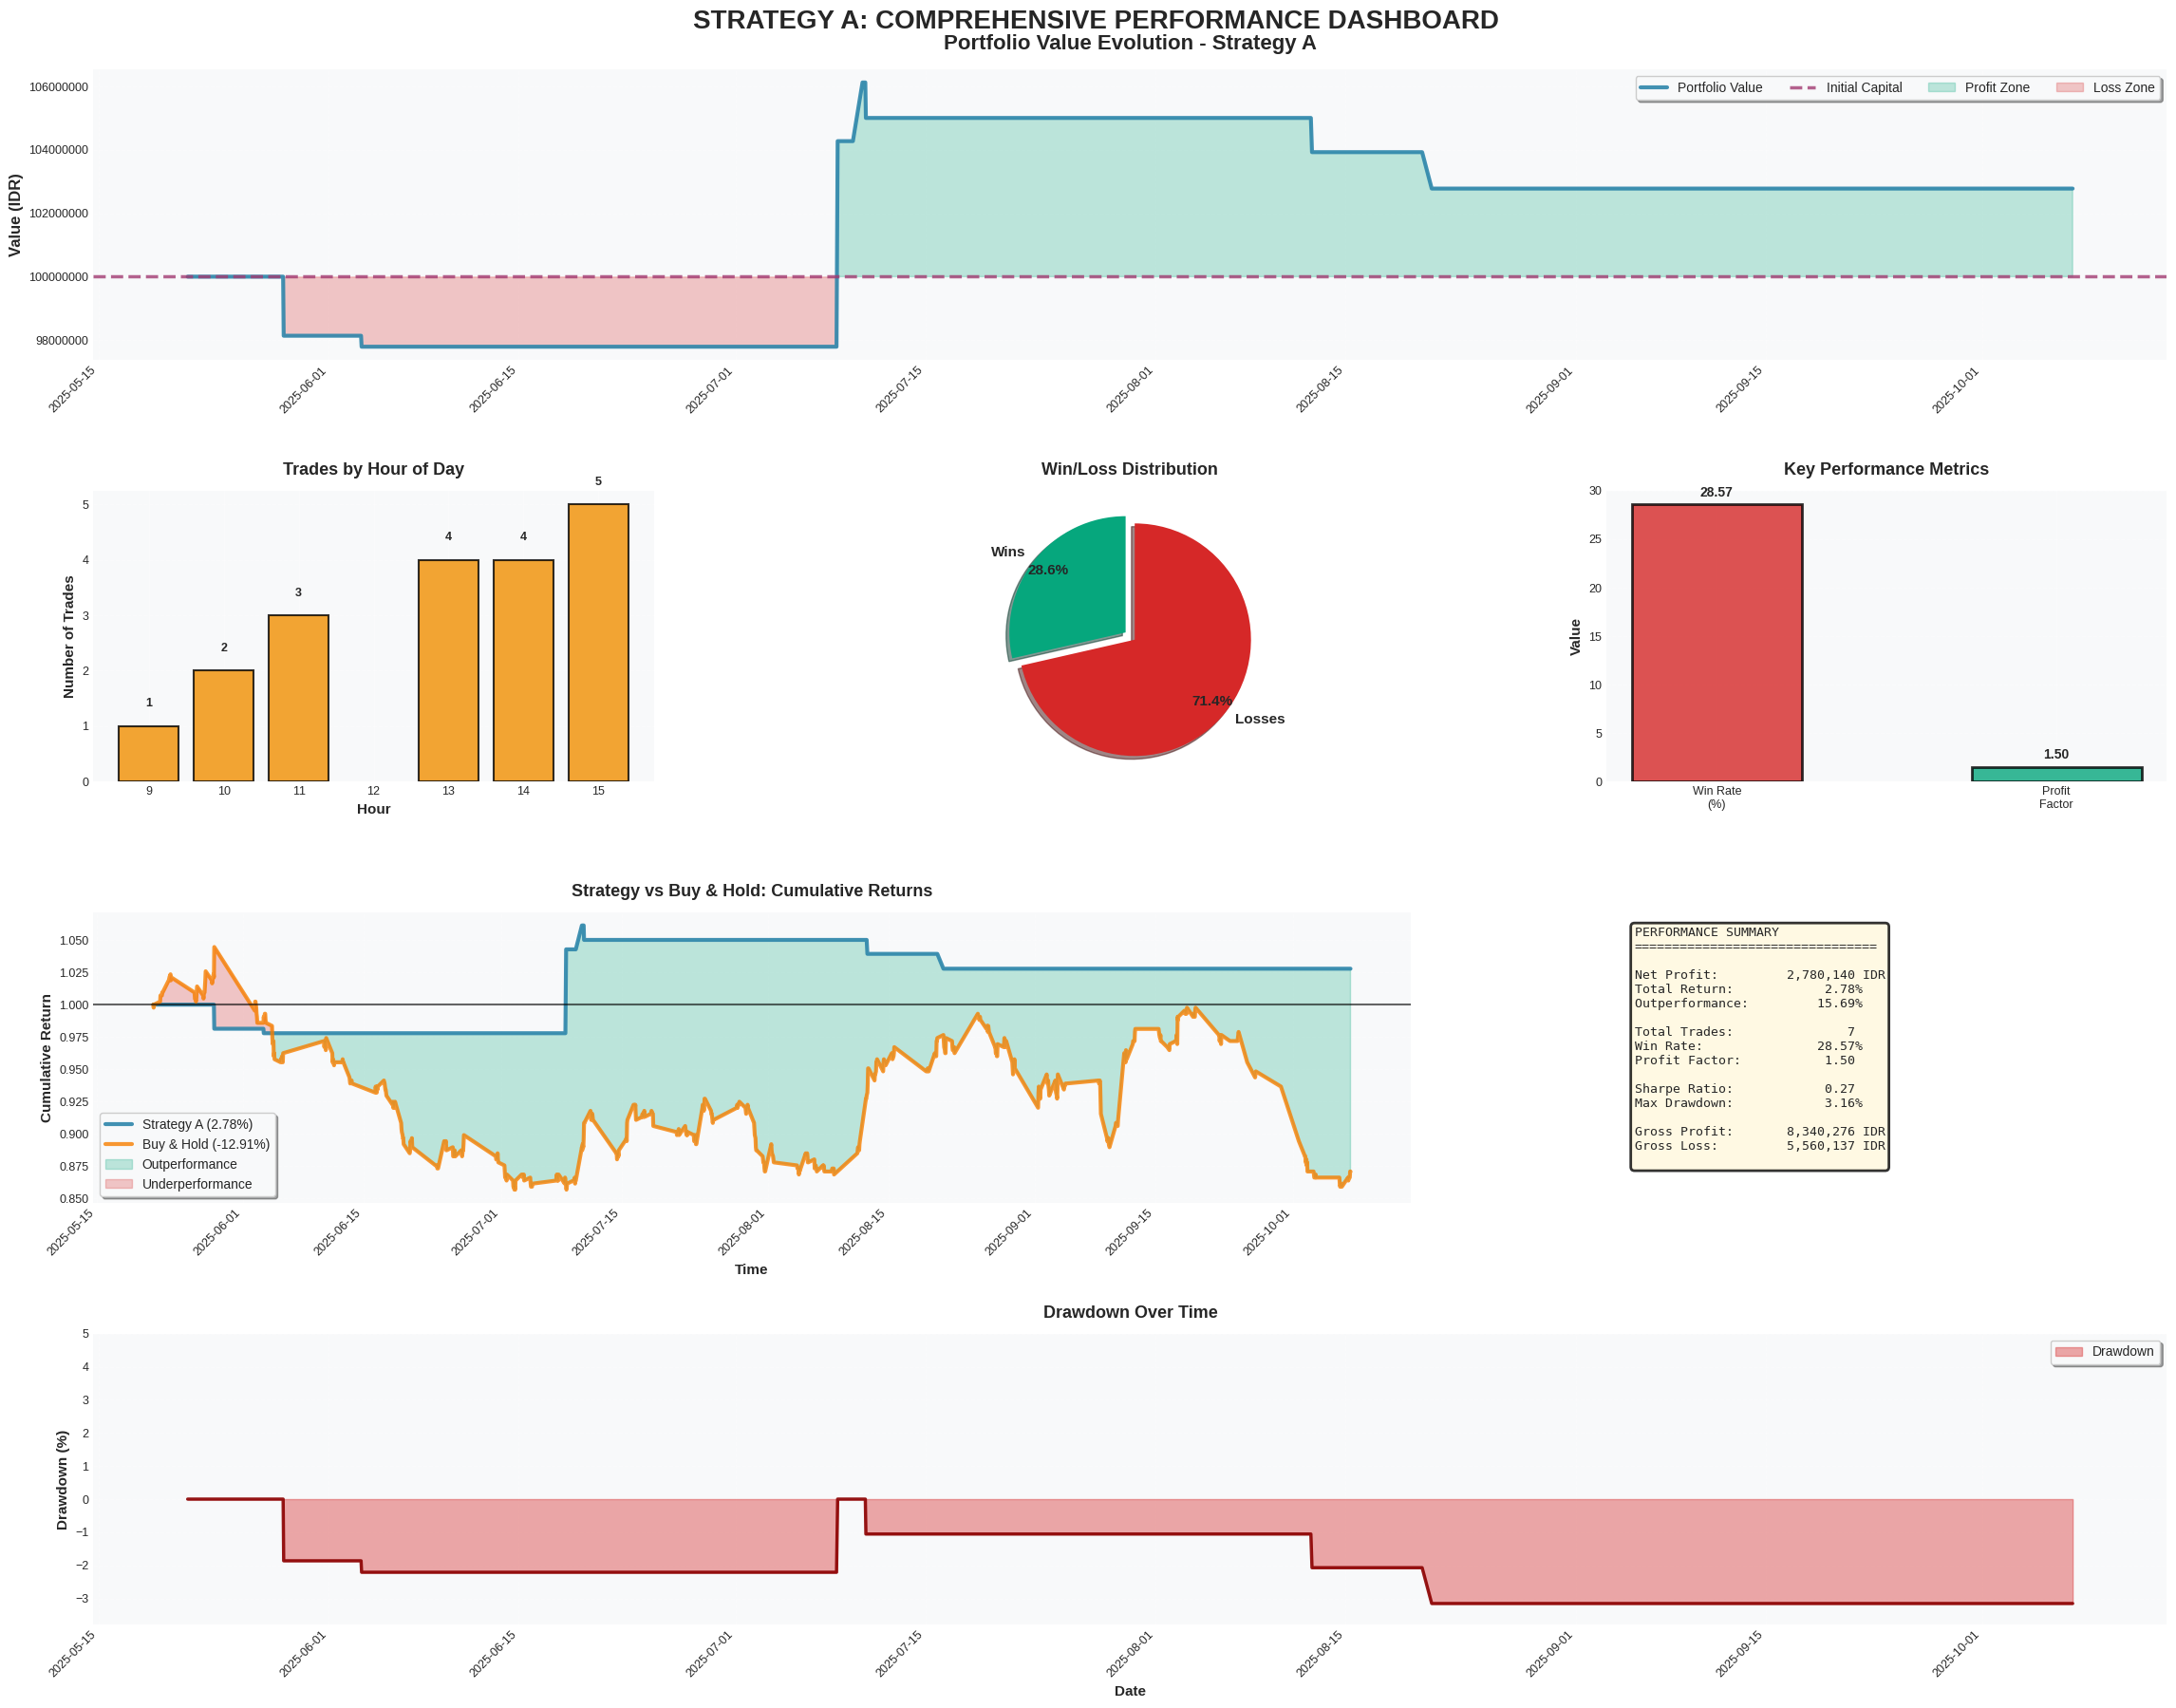


✓ STRATEGY A VISUALIZATION COMPLETED!


In [ ]:
# Parameter backtesting
INITIAL_CAPITAL = 100000000  # Modal awal
RISK_PER_TRADE = 0.5  # Risk 30% per trade
SENTIMENT_BULLISH_THRESHOLD = 0.6  # Threshold untuk weighted bullish (score * 1)
SENTIMENT_BEARISH_THRESHOLD = 0.4  # Threshold untuk weighted bearish (score * -1), pakai 0.4 sbg nilai absolut

print("="*60)
print("BACKTESTING SYSTEM STRATEGY A - BBRI")
print("="*60)

# --- 3. Run backtesting ---
backtest_results_BBRI, performance_metrics_BBRI = backtest_strategy_A(
    df_with_sentiment,
    initial_capital=INITIAL_CAPITAL,
    risk_per_trade=RISK_PER_TRADE,
    sentiment_bullish_threshold=SENTIMENT_BULLISH_THRESHOLD,
    sentiment_bearish_threshold=SENTIMENT_BEARISH_THRESHOLD
    )

# --- 4. Visualisasi ---
if backtest_results_BBRI is not None:
  plot_strategy_A_results(backtest_results_BBRI, performance_metrics_BBRI)

# Backtesting Strategy B

Running LSTM backtesting strategy...

Running LSTM Backtest with window_T = 10 DAYS.

LSTM BACKTESTING RESULTS (STRATEGY B)
Initial Capital:      IDR          100,000,000
Final Capital:        IDR          114,183,408
Net Profit:           IDR           14,183,408
Total Return:                            14.18%
Buy & Hold Return:                      -12.91%
Outperformance:                          27.09%

Number of Trades:                           32
Winning Trades:                             15
Losing Trades:                               1
Win Rate:                                93.75%

Gross Profit:         IDR           14,432,990
Gross Loss:           IDR              249,582
Profit Factor:                           57.83

Sharpe Ratio:                            18.05
Max Drawdown:                             1.98%
Max Drawdown Value:   IDR            2,138,478

GENERATING ENHANCED VISUALIZATIONS FOR STRATEGY B


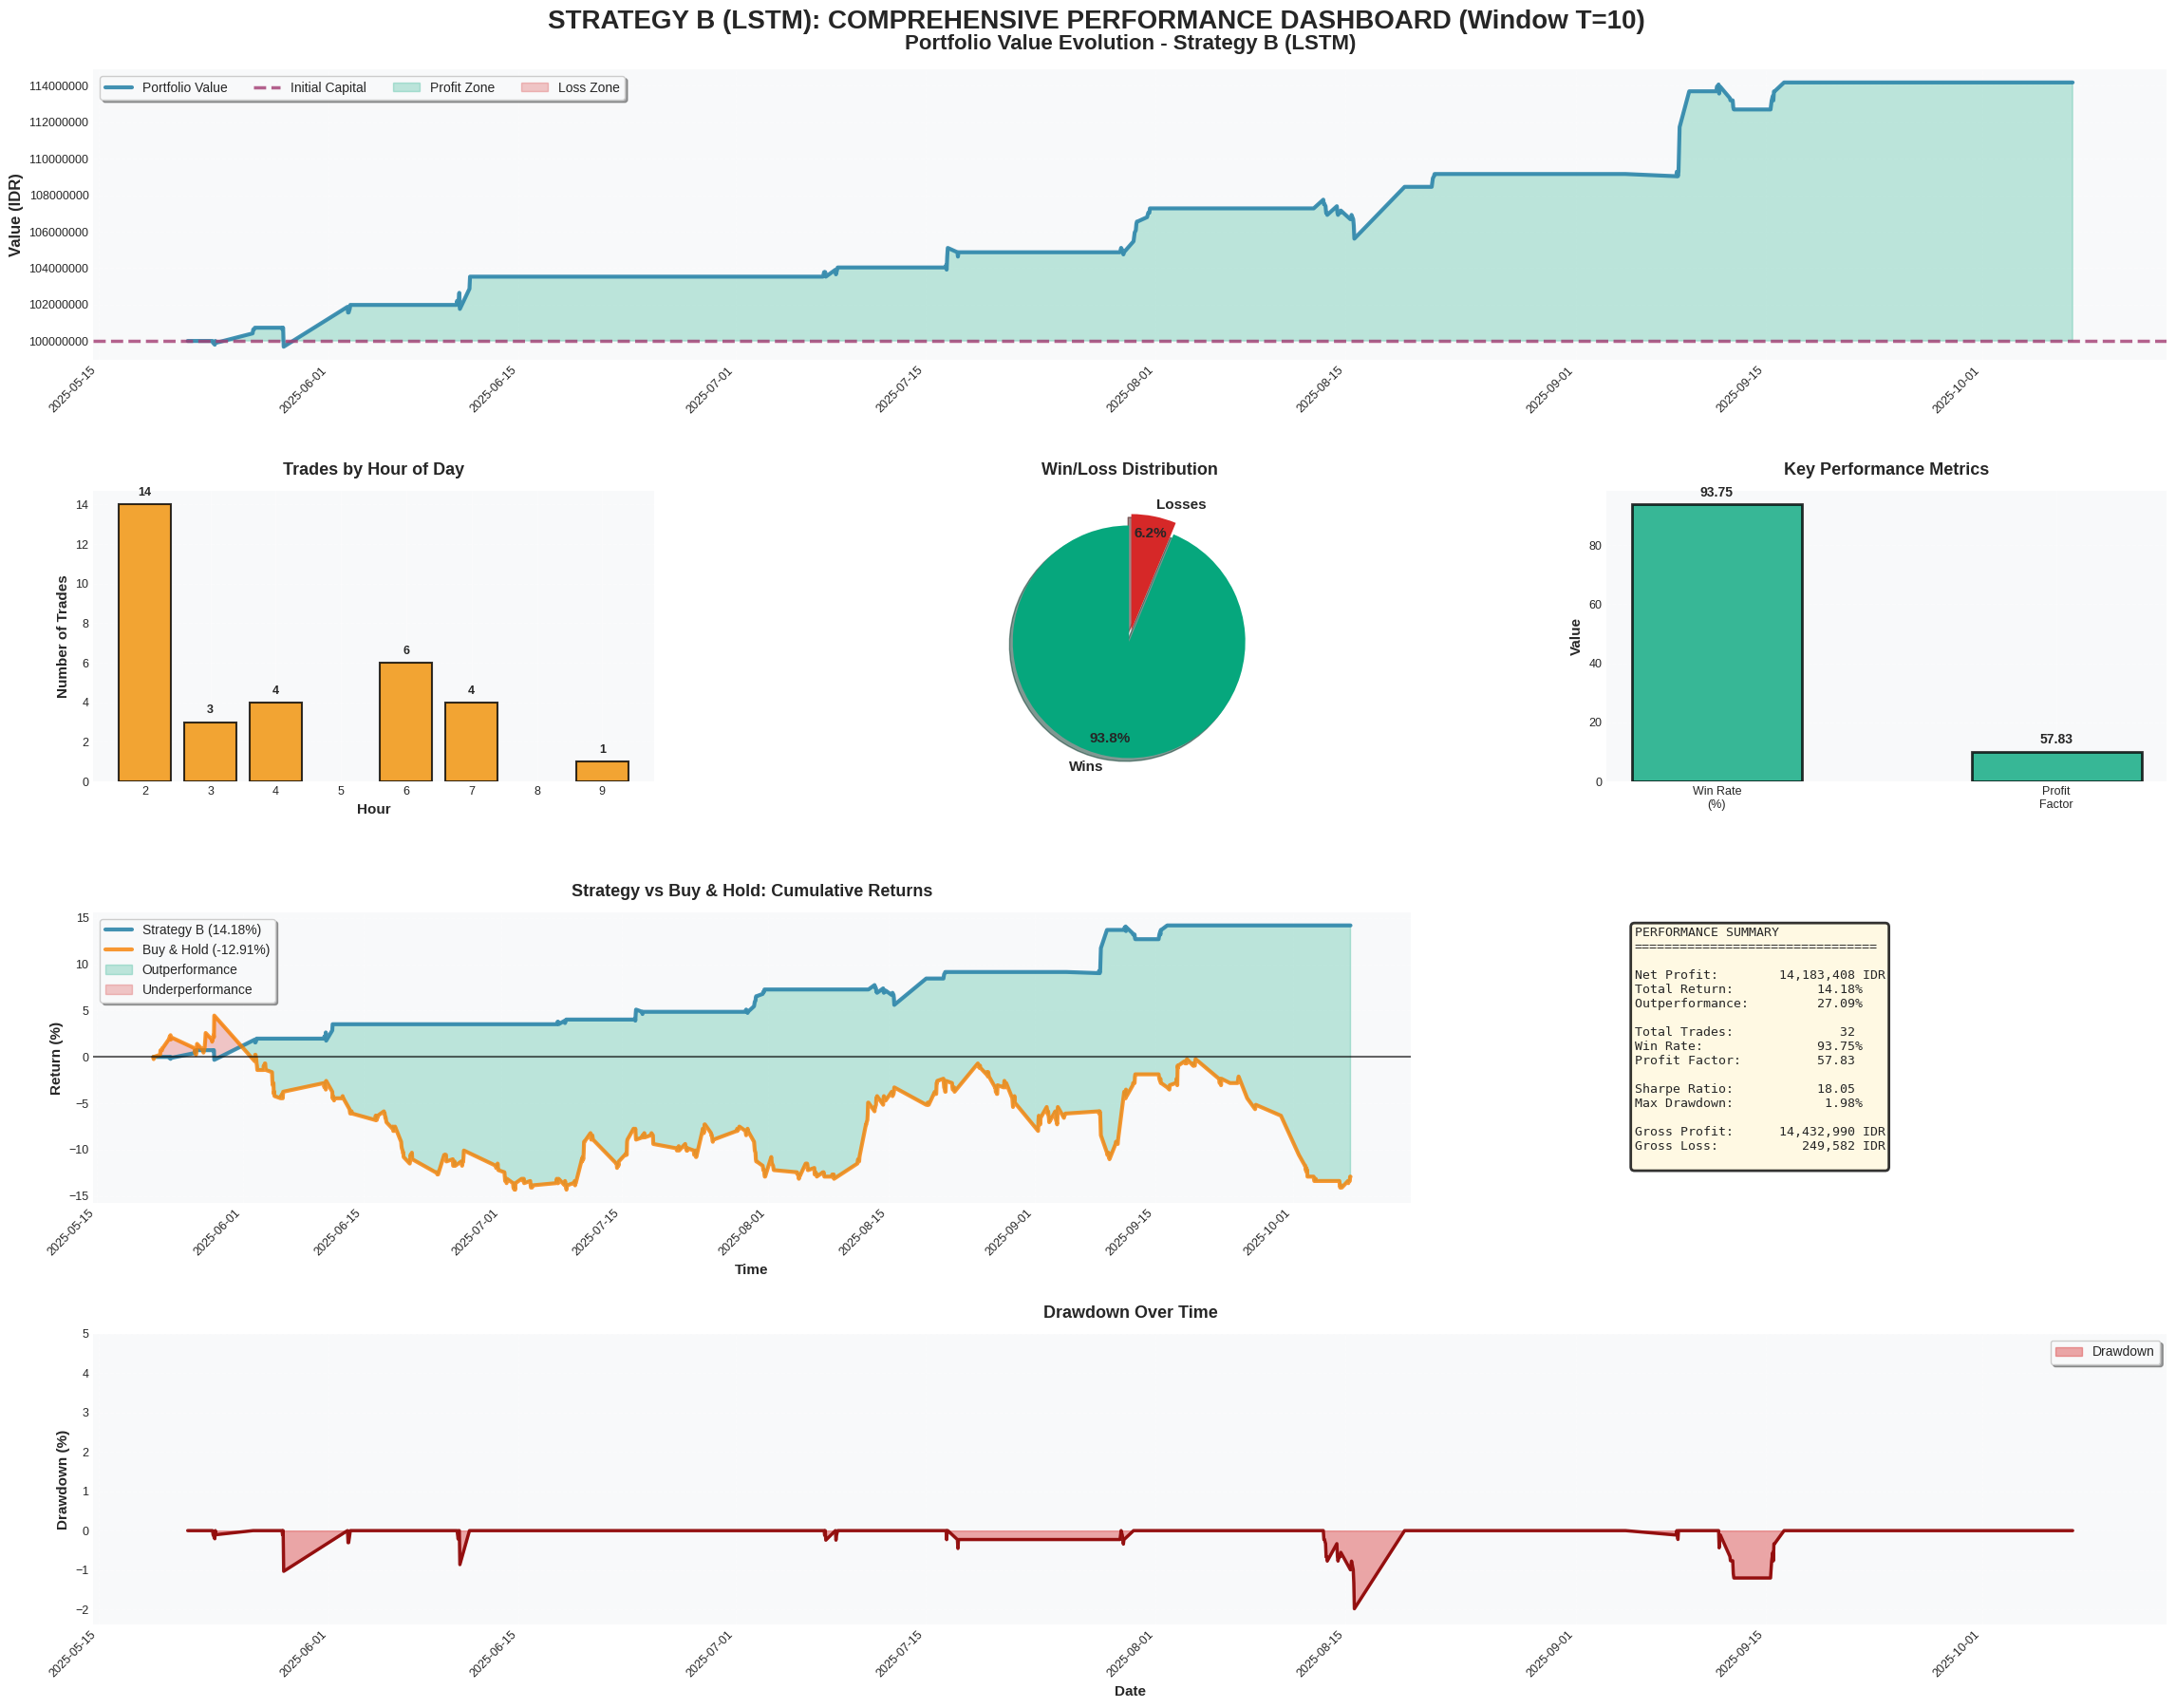


✓ STRATEGY B VISUALIZATION COMPLETED!


In [ ]:
# ========================================
# RUN BACKTESTING
# ========================================
print("Running LSTM backtesting strategy...")

backtest_results = backtest_strategy_B(
    actual_prices=df_with_sentiment['Close'].values,
    predicted_prices=df_with_sentiment['Close_Predicted'].values,
    sentiment_scores=df_with_sentiment['Sentiment_value'].values,
    sentiment_probabilities=df_with_sentiment['ABS_Average_Score'].values,
    datetimes=df_with_sentiment['Datetime'].values,
    initial_capital=100000000,  # 100 million IDR
    risk_percentage=0.45,  # 30% risk per trade
    window_T=10  # 10-hours window
)

# Display Results
print("\n" + "="*100)
print("LSTM BACKTESTING RESULTS (STRATEGY B)")
print("="*100)
print(f"Initial Capital:      IDR {backtest_results['initial_capital']:>20,.0f}")
print(f"Final Capital:        IDR {backtest_results['final_capital']:>20,.0f}")
print(f"Net Profit:           IDR {backtest_results['net_profit']:>20,.0f}")
print(f"Total Return:             {backtest_results['total_return_pct']:>20,.2f}%")
print(f"Buy & Hold Return:        {backtest_results['buy_hold_return_pct']:>20,.2f}%")
print(f"Outperformance:           {backtest_results['outperformance']:>20,.2f}%")

print(f"\nNumber of Trades:         {backtest_results['num_trades']:>20}")
print(f"Winning Trades:           {backtest_results['num_wins']:>20}")
print(f"Losing Trades:            {backtest_results['num_losses']:>20}")
print(f"Win Rate:                 {backtest_results['win_rate']:>20,.2f}%")

print(f"\nGross Profit:         IDR {backtest_results['gross_profit']:>20,.0f}")
print(f"Gross Loss:           IDR {backtest_results['gross_loss']:>20,.0f}")
print(f"Profit Factor:            {backtest_results['profit_factor']:>20,.2f}")

print(f"\nSharpe Ratio:             {backtest_results['sharpe_ratio']:>20,.2f}")
print(f"Max Drawdown:             {backtest_results['max_drawdown_pct']:>20,.2f}%")
print(f"Max Drawdown Value:   IDR {backtest_results['max_drawdown_value']:>20,.0f}")
print('='*100)
plot_strategy_B_results(backtest_results, df_final_BBRI, window_T=10)

In [ ]:
def export_comparison_metrics(metrics_A, backtest_results_B):
    """
    Export comparison metrics to CSV file
    """
    comparison_data = {
        'Metric': [
            'Initial Capital (IDR)',
            'Final Capital (IDR)',
            'Net Profit (IDR)',
            'Total Return (%)',
            'Buy & Hold Return (%)',
            'Outperformance (%)',
            'Total Trades',
            'Winning Trades',
            'Losing Trades',
            'Win Rate (%)',
            'Profit Factor',
            'Sharpe Ratio',
            'Max Drawdown (%)',
            'Max Drawdown (IDR)',
            'Gross Profit (IDR)',
            'Gross Loss (IDR)'
        ],
        'Strategy A': [
            metrics_A['Initial Capital'],
            metrics_A['Final Capital'],
            metrics_A['Total Net Profit'],
            metrics_A['Total Return (%)'],
            metrics_A['Buy & Hold Return (%)'],
            metrics_A['Excess Return (%)'],
            metrics_A['Total Trades'],
            metrics_A['Winning Trades'],
            metrics_A['Losing Trades'],
            metrics_A['Win Rate (%)'],
            metrics_A['Profit Factor'],
            metrics_A['Sharpe Ratio'],
            metrics_A['Max Drawdown (%)'],
            metrics_A['Max Drawdown ($)'],
            metrics_A['Gross Profit'],
            metrics_A['Gross Loss']
        ],
        'Strategy B': [
            backtest_results_B['initial_capital'],
            backtest_results_B['final_capital'],
            backtest_results_B['net_profit'],
            backtest_results_B['total_return_pct'],
            backtest_results_B['buy_hold_return_pct'],
            backtest_results_B['outperformance'],
            backtest_results_B['num_trades'],
            backtest_results_B['num_wins'],
            backtest_results_B['num_losses'],
            backtest_results_B['win_rate'],
            backtest_results_B['profit_factor'],
            backtest_results_B['sharpe_ratio'],
            backtest_results_B['max_drawdown_pct'],
            backtest_results_B['max_drawdown_value'],
            backtest_results_B['gross_profit'],
            backtest_results_B['gross_loss']
        ]
    }

    df_comparison = pd.DataFrame(comparison_data)
    return df_comparison

In [ ]:
def print_comparison_summary(metrics_A, backtest_results_B):
    """
    Print side-by-side comparison summary
    """
    print("\n" + "="*100)
    print(" " * 30 + "STRATEGY COMPARISON SUMMARY")
    print("="*100)
    print(f"\n{'Metric':<30} {'Strategy A':>20} {'Strategy B':>20} {'Winner':>20}")
    print("-" * 100)

    # Returns
    return_A = metrics_A['Total Return (%)']
    return_B = backtest_results_B['total_return_pct']
    winner = 'Strategy A' if return_A > return_B else 'Strategy B'
    print(f"{'Total Return (%)':<30} {return_A:>20.2f} {return_B:>20.2f} {winner:>20}")

    # Win Rate
    wr_A = metrics_A['Win Rate (%)']
    wr_B = backtest_results_B['win_rate']
    winner = 'Strategy A' if wr_A > wr_B else 'Strategy B'
    print(f"{'Win Rate (%)':<30} {wr_A:>20.2f} {wr_B:>20.2f} {winner:>20}")

    # Profit Factor
    pf_A = metrics_A['Profit Factor']
    pf_B = backtest_results_B['profit_factor']
    winner = 'Strategy A' if pf_A > pf_B else 'Strategy B'
    print(f"{'Profit Factor':<30} {pf_A:>20.2f} {pf_B:>20.2f} {winner:>20}")

    # Sharpe Ratio
    sr_A = metrics_A['Sharpe Ratio']
    sr_B = backtest_results_B['sharpe_ratio']
    winner = 'Strategy A' if sr_A > sr_B else 'Strategy B'
    print(f"{'Sharpe Ratio':<30} {sr_A:>20.2f} {sr_B:>20.2f} {winner:>20}")

    # Max Drawdown (lower is better)
    dd_A = metrics_A['Max Drawdown (%)']
    dd_B = backtest_results_B['max_drawdown_pct']
    winner = 'Strategy A' if dd_A < dd_B else 'Strategy B'
    print(f"{'Max Drawdown (%)':<30} {dd_A:>20.2f} {dd_B:>20.2f} {winner:>20}")

    # Total Trades
    trades_A = metrics_A['Total Trades']
    trades_B = backtest_results_B['num_trades']
    print(f"{'Total Trades':<30} {trades_A:>20} {trades_B:>20} {'-':>20}")

    print("\n" + "="*100)

    # Overall Winner
    scores = {
        'Strategy A': 0,
        'Strategy B': 0
    }

    if return_A > return_B: scores['Strategy A'] += 1
    else: scores['Strategy B'] += 1

    if wr_A > wr_B: scores['Strategy A'] += 1
    else: scores['Strategy B'] += 1

    if pf_A > pf_B: scores['Strategy A'] += 1
    else: scores['Strategy B'] += 1

    if sr_A > sr_B: scores['Strategy A'] += 1
    else: scores['Strategy B'] += 1

    if dd_A < dd_B: scores['Strategy A'] += 1
    else: scores['Strategy B'] += 1

    overall_winner = 'Strategy A' if scores['Strategy A'] > scores['Strategy B'] else 'Strategy B'

    print(f"\nOVERALL WINNER: {overall_winner}")
    print(f"Score: Strategy A = {scores['Strategy A']}/5, Strategy B = {scores['Strategy B']}/5")
    print("="*100 + "\n")


GENERATING STRATEGY COMPARISON VISUALIZATION


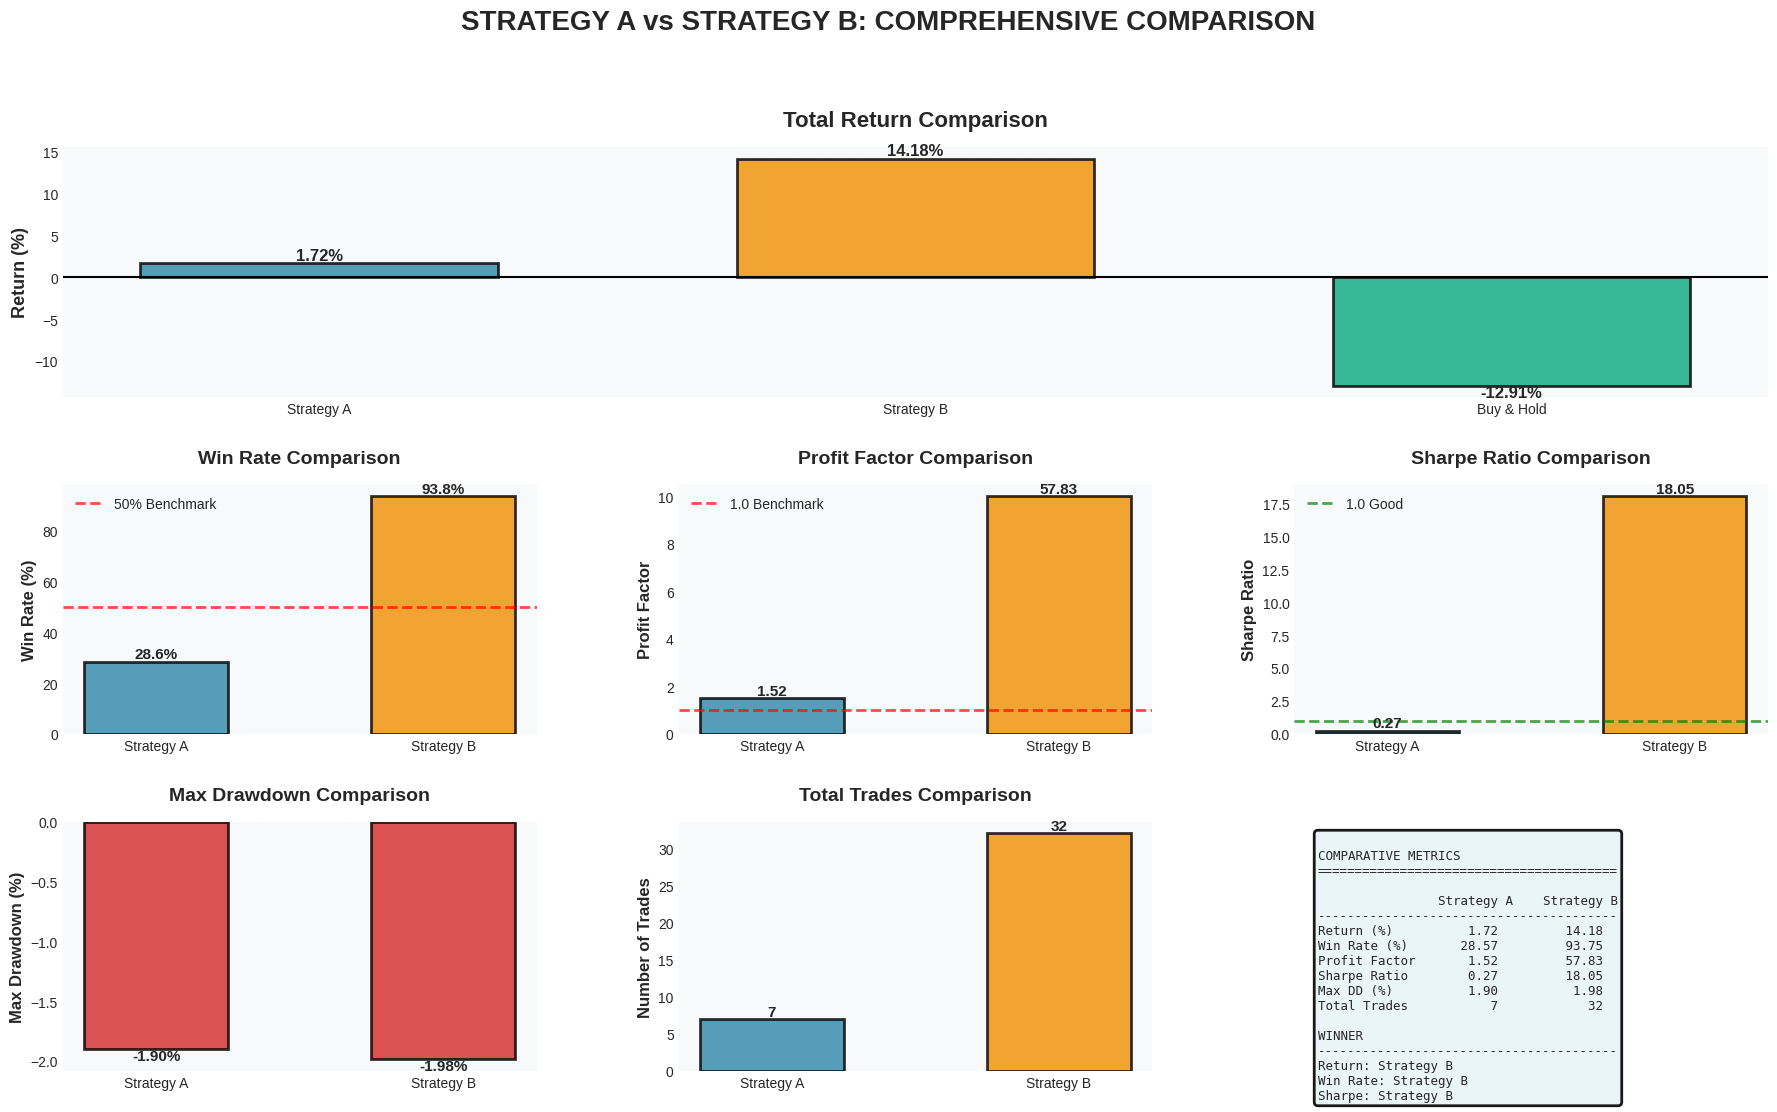


✓ COMPARISON VISUALIZATION COMPLETED!

                              STRATEGY COMPARISON SUMMARY

Metric                                   Strategy A           Strategy B               Winner
----------------------------------------------------------------------------------------------------
Total Return (%)                               1.72                14.18           Strategy B
Win Rate (%)                                  28.57                93.75           Strategy B
Profit Factor                                  1.52                57.83           Strategy B
Sharpe Ratio                                   0.27                18.05           Strategy B
Max Drawdown (%)                               1.90                 1.98           Strategy A
Total Trades                                      7                   32                    -


OVERALL WINNER: Strategy B
Score: Strategy A = 1/5, Strategy B = 4/5



,Metric,Strategy A,Strategy B
0,Initial Capital (IDR),1.000000e+08,1.000000e+08
1,Final Capital (IDR),1.017215e+08,1.141834e+08
2,Net Profit (IDR),1.721514e+06,1.418341e+07
3,Total Return (%),1.721514e+00,1.418341e+01
4,Buy & Hold Return (%),-1.291080e+01,-1.291080e+01
5,Outperformance (%),1.463231e+01,2.709421e+01
6,Total Trades,7.000000e+00,3.200000e+01
7,Winning Trades,2.000000e+00,1.500000e+01
8,Losing Trades,5.000000e+00,1.000000e+00
9,Win Rate (%),2.857143e+01,9.375000e+01


In [ ]:
plot_strategy_comparison(performance_metrics_BBRI, backtest_results, backtest_results_BBRI, backtest_results)
print_comparison_summary(performance_metrics_BBRI, backtest_results)
export_comparison_metrics(performance_metrics_BBRI, backtest_results)